<a href="https://colab.research.google.com/github/bilgin-kocak/fenics-tutorials-anders-logg/blob/master/Exercise_5a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 5a: Application to Elasticity (linear)
![image.png](attachment:image.png)

In this exercise, we will solve the equations of linear elasticity with FEniCS:

\begin{alignat}{2}
-\nabla\cdot\sigma(u) &= f \quad && \text{in } \Omega \\
u &= u_{\mathrm{L}} \quad && \text{on } \Gamma_{\mathrm{L}} \\
u &= u_{\mathrm{R}} \quad && \text{on } \Gamma_{\mathrm{R}} \\
\sigma\cdot n &= g \quad && \text{on } \Gamma_{\mathrm{N}}
\end{alignat}

where $\sigma(u) = 2\mu\varepsilon(u) + \lambda\mathrm{tr}(\varepsilon(u)) I$ is the Cauchy stress tensor, $\varepsilon(u) = \frac{1}{2}(\nabla u + (\nabla u)^{\top})$ is the strain tensor (symmetric gradient) and $I$ is the identity matrix.

This is a model of linear elastic materials in the idealized case of infinitesimal (small) displacements.

We will use the following data:

* $\Omega = (0,2)\times(0,1)\times(0,1)$
* $G = 79300\,\mathrm{[Pa]}$ (shear modulus)
* $K = 160000\,\mathrm{[Pa]}$ (bulk modulus)
* $f = (0,0,0)$
* $\Gamma_{\mathrm{L}} = \{(x,y,z) \in \partial\Omega \mid x = 0\}$ (the left boundary)
* $\Gamma_{\mathrm{R}} = \{(x,y,z) \in \partial\Omega \mid x = 2\}$ (the right boundary)
* $\Gamma_{\mathrm{N}} = \partial\Omega \setminus (\Gamma_{\mathrm{L}} \cup \Gamma_{\mathrm{R}})$
* $u_{\mathrm{L}} = (0,0,0)$ (fixed)
* $u_{\mathrm{R}} = (1, 0.5-y+(y-z)/\sqrt{2}, 0.5-z+(y+z-1)/\sqrt{2})$ (stretched and rotated)
* $g = (0,0,0)$

Compute the Lamé parameters $\mu$ and $\lambda$ from the shear modulus and bulk modulus. The given values are those of steel scaled down by a factor $10^6$.

For hints and more reading on how to solve this problem in FEniCS, see the [section on the equations of linear elasticity](https://fenicsproject.org/pub/tutorial/html/._ftut1008.html#ftut:elast) in the [FEniCS Tutorial](https://fenicsproject.org/tutorial/).

## Importing FEniCS
The first thing we need to do is to import FEniCS.

In [ ]:
# Installing and Importing Fenics
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
    from fenics import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from fenics import *; from mshr import *
    
dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

## Initializing notebook plotting
When running in a Jupyter notebook, a special line is necessary to show FEniCS plots in the notebook.

In [ ]:
%matplotlib inline

## Creating the mesh
To create the mesh, use the `BoxMesh` class with mesh size $h = 1/16$.

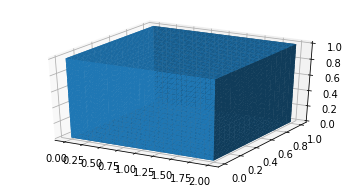

In [ ]:
mesh = BoxMesh(Point(0,0,0),Point(2,1,1),32,16,16)
plot(mesh)

## Defining the finite element function space
When we have created the mesh, we can define the finite element function space. Since we will be solving a system of equations for $u = (u_x, u_y, u_z)$, we create a $P_1$ *vector* function space.

In [ ]:
V = VectorFunctionSpace(mesh, 'P', 1)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


## Defining the boundary conditions
The boundary conditions can be defined by specifying all points on the boundary close to either of the two end points $x = 0$ and $x = 2$. Use two `DirichletBC` objects to define the two boundary conditions. Note that the traction boundary condition $g = 0$ is a natural boundary condition and so does not need to be implemented as a Dirichlet boundary condition.

In [ ]:
def left(x, on_boundary):
    return on_boundary and near(x[0], 0.0)

def right(x, on_boundary):
    return on_boundary and near(x[0], 2.0)

u_L = Constant((0,0,0))
u_R = Expression(('1.0', '0.5 - x[1] + (x[1] - x[2])/sqrt(2.0)', '0.5 - x[2] + (x[1] + x[2] - 1.0)/sqrt(2.0)'), degree=1) 

bc_L = DirichletBC(V, u_L, left)
bc_R = DirichletBC(V, u_R, right)
bcs = [bc_L, bc_R]

## Defining the variational problem
The finite element variational problem for the linear elasticy problem reads: Find $u \in V$ such that
$$
\int_{\Omega} \sigma(u) : \varepsilon(v) \,\mathrm{d}x
=
\int_{\Omega} f \cdot v \,\mathrm{d}x
$$
for all $v \in V$.

This can be expressed in FEniCS by defining the *bilinear form* $a$ and the *linear form* $L$:

\begin{align}
  a(u, v) &= \int_{\Omega} \sigma(u) : \varepsilon(v) \,\mathrm{d}x, \\
  L(v) &= \int_{\Omega} f \cdot v \,\mathrm{d}x.
\end{align}

where $\sigma(u) = 2\mu\varepsilon(u) + \lambda\mathrm{tr}(\varepsilon(u)) I$ and $\varepsilon(u) = \frac{1}{2}(\nabla u + (\nabla u)^{\top})$. Note that both $\sigma$ and $\varepsilon$ may be conveniently expressed as Python functions using the `def` keyword.

In [ ]:
G = 79300.0
K = 160000.0
mu = Constant(G)
lmbda = Constant(K- 2.0*G/3.0)
f = Constant((0,0,0))
d = 3

def epsilon(u):
    return sym(grad(u))

def sigma(u):
    return 2*mu*epsilon(u) + lmbda*tr(epsilon(u))*Identity(d)

u = TrialFunction(V)
v = TestFunction(V)
a = inner(sigma(u), epsilon(v))*dx
L = dot(f,v)*dx

## Solving the variational problem
As an alternative to calling the `solve()` function, we manually assemble the linear system, apply the boundary conditions and solve the linear system.

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


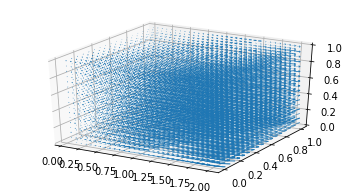

In [ ]:
A = assemble(a)
b = assemble(L)

for bc in bcs:
    bc.apply(A, b)
# Alternative
A, b = assemble_system(a, L, bcs)

u = Function(V)
solve(A, u.vector(), b, 'gmres', 'ilu')

plot(u)

## Computing the von Mises stress
The von Mises stress is defined by
\begin{equation}
\sigma_v = \sqrt{\frac{3}{2} s:s}  
\end{equation}
where
\begin{equation}
s = \mathrm{dev}(\sigma) = \sigma - \frac{1}{3}\mathrm{tr}(\sigma)I
\end{equation}
is the *deviatoric stress tensor*. This can be expressed in FEniCS using the `dev()` operator.

In [ ]:
s = dev(sigma(u))
sv = sqrt(1.5*inner(s,s))

sv_avg = assemble(sv*dx)/assemble(1*dx(mesh))
print(sv_avg)

W = FunctionSpace(mesh, 'DG', 0)
sv = project(sv, W)
sv_max = sv.vector().norm('linf')
print(sv_max)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
104470.82377426552
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
164863.81455294852


## Postprocessing
To postprocess the solution using an external postprocessor, for example Paraview, save the solution to VTK format (file suffix `.pvd`).

In [ ]:
File('exercise5/solution_linear.pvd') << u